# Notebook B : Document clustering and comparaison

Began 21 May 2020 by Amaury de Barbuat from ECL

Updated by William Riou from ENSTA PARIS

## 0- Intro

First part is for clustering previous doc vectors and computing their centroid vector


Second part is for testing whether a new document belongs to a cluster or is a new type of doc

## 1- Clustering and centroids computation

'Notebook A' has provided a vector for each document, now we want to make clusters of them. To do so we will look for the right number of clusters to ask for with k means method. Then we will compute each cluster's centroid.

In [1]:
# load vectors in txt file
# put them in the right format
# do clustering with k means
# evaluate our clusters with a score
# compute centroids of the clusters

### 11- Creating list of report vectors

In [2]:
def w2vreports_to_list_of_report_vectors(filename):

    file = open(filename, "r")
    lines = file.readlines()
    file.close()

    report_vectors = [] # will contain every vectors as sublists e.g. [[0.13, ..., -0.87], [-0.45, ..., 0.02], ...]

    for line in lines :
        line = line.split() # turn into list each line, they contain the word and its n dimensions
        report_vector = [float(i) for i in line]
        report_vectors.append(report_vector)
    
    return report_vectors

In [3]:
report_vectors = w2vreports_to_list_of_report_vectors('w2v_doc_vectors_57_100d_5e.txt')

### 12- Document vector K-means algorithm

In [4]:
# entry : matrix of doc vectors (each line is a vector) and number of desired clusters

# outputs :
# labels : list of cluster numbers corresponding to the inputs
# centroids : vectors which point the center of each cluster

def kmeans(report_vectors, num_clusters, num_runs, max_iterations):

    from sklearn import cluster
    from sklearn import metrics
    m=num_clusters
    n=num_runs # default=10
    p=max_iterations # default=300
    kmeans = cluster.KMeans(n_clusters=m, n_init=n, max_iter=p)
    kmeans.fit(report_vectors)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    n_iterations = kmeans.n_iter_
    inertia = kmeans.inertia_
    
    return (labels, centroids, n_iterations, inertia)

In [5]:
labels, centroids, n_iterations, inertia = kmeans(report_vectors,57,10,300)

### 13- Store labels and centroids created

In [6]:
def store_labels(entry_list, output_filename):
    
    MyFile=open(output_filename,'w')

    for e in entry_list:
        MyFile.write(str(e)+'\n')
        
    MyFile.close()

In [7]:
store_labels(labels, 'labels_57_100d_5e.txt')

In [8]:
def store_centroids(entry_list, output_filename):
    
    MyFile=open(output_filename,'w')

    for e in entry_list:
        e = e.tolist()
        for i in range(len(e)):
            MyFile.write(str(e[i])+' ')
        MyFile.write('\n')
        
    MyFile.close()

In [9]:
store_centroids(centroids, 'centroids_57_100d_5e.txt')

### 14- Study intra-cluster quality

In [10]:
def find_lowest_similarity_in_a_cluster(label_of_studied_cluster, labels, centroids, report_vectors):
    # get vector members of our new report closest cluster
    cluster_members=[]
    for i in range (len(labels)):
        if labels[i]==label_of_studied_cluster:
            cluster_members.append(report_vectors[i])

    # list of distances between the centroid and vectors of the cluster
    from sklearn.metrics.pairwise import cosine_similarity
    similarities=[]
    cluster_center=centroids[label_of_studied_cluster]
    for e in cluster_members:
        similarities.append(cosine_similarity([e], [cluster_center])[0][0])

    # find the lowest similarity score inside the cluster
    min_sim = min(similarities)
    return min_sim

In [11]:
def intra_cluster_check(labels, centroids, report_vectors):
    T=[]
    for i in range (max(labels)+1):
        lowest_sim = find_lowest_similarity_in_a_cluster(i, labels, centroids, report_vectors)
        T.append(lowest_sim)
    return T

In [12]:
def evaluate_lowesim(lowesim):
    L1, L2, L3, L4 = [], [], [], []
    n=len(lowesim)
    for e in lowesim:
        if 0.90<e:
            L1.append(e)
        elif 0.80<e<=0.90:
            L2.append(e)
        elif 0.70<e<=0.80:
            L3.append(e)
        elif 0.60<e<=0.70:
            L4.append(e)
    print(len(L4)/n, len(L3)/n, len(L2)/n, len(L1)/n)
    print(L4)

In [13]:
lowesim = intra_cluster_check(labels, centroids, report_vectors)

In [14]:
evaluate_lowesim(lowesim)

0.0 0.0 0.0 1.0
[]


### 15- Study inter-cluster quality

In [15]:
def inter_cluster_check(report_vectors, labels):
    
    from sklearn.metrics import silhouette_score
    score = silhouette_score(report_vectors, labels)
    print(score)

In [16]:
inter_cluster_check(report_vectors, labels)

0.20655739258237144


### 16- Evaluate clustering quality

In [19]:
# entries : vectors and their associated cluster labels
# output : davies_bouldin_score (close to 0 means good clustering quality in terms of separation and consistency)

def evaluate_clustering_quality(report_vectors, labels):
    
    from sklearn.metrics import davies_bouldin_score
    score = davies_bouldin_score(report_vectors, labels)
    print(score)

In [20]:
evaluate_clustering_quality(report_vectors, labels)

0.9863186696107779


In [21]:
labels, centroids, n_iterations, inertia = kmeans(report_vectors, 300, 40, 50)
print(inertia)
lowesim = intra_cluster_check(labels, centroids, report_vectors)
evaluate_lowesim(lowesim)
inter_cluster_check(report_vectors, labels)
evaluate_clustering_quality(report_vectors, labels)

0.010466043244516356
0.0 0.0 0.0 1.0
[]
0.07263364746416134
0.3374740256381564


In [22]:
labels, centroids, n_iterations, inertia = kmeans(report_vectors, 2, 40, 50)
print(inertia)
lowesim = intra_cluster_check(labels, centroids, report_vectors)
evaluate_lowesim(lowesim)
inter_cluster_check(report_vectors, labels)
evaluate_clustering_quality(report_vectors, labels)

2.5809598610879676
0.0 0.0 0.0 1.0
[]
0.4392108306272217
0.8741339787439952


### 17- Number of clusters optimization

In [23]:
# entry :  txt file of doc vectors in w2v format
# output : draw graph and give the min of it

def find_right_number_of_clusters(filename, start_num_clusters, end_num_clusters): # start_num_clusters >= 2
    
    # import useful libraries
    from sklearn.metrics import davies_bouldin_score
    import matplotlib.pyplot as plt
    
    # create lists of vectors
    report_vectors = w2vreports_to_list_of_report_vectors(filename)
    
    # iterate over the number of clusters to determine which number gets the best score in the end
    X=[k for k in range (start_num_clusters, end_num_clusters+1, 50)]
    
    # build a list of scores for each number of clusters
    Y=[]
    
    for i in X:
        
        # build the clusters
        labels, centroids, n_iterations, inertia = kmeans(report_vectors, i, 10, 10)
        
        # evaluate those clusters
        #score = davies_bouldin_score(report_vectors, labels)
        score = inertia
        
        Y.append(score)
    
    if len(X) >= 2 :
        plt.plot(X, Y)
        plt.ylabel("Score")
        plt.xlabel("Number of clusters")
        plt.show()
    
    m = min(Y)
    m_ind = Y.index(m)
    n = X[m_ind]
    
    print ('minimum davies bouldin score : ', m) 
    print('corresponding number of clusters : ', n)

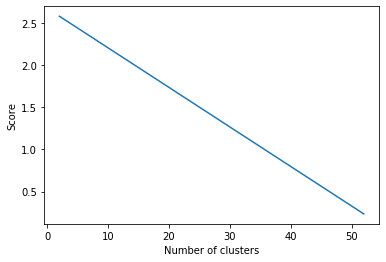

minimum davies bouldin score :  0.23409142675550443
corresponding number of clusters :  52


In [24]:
find_right_number_of_clusters('w2v_doc_vectors_57_100d_5e.txt', 2, 100)

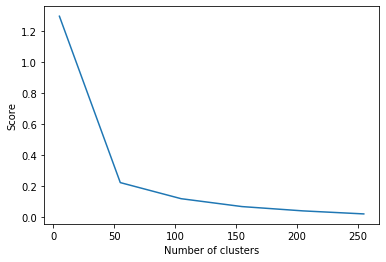

minimum davies bouldin score :  0.021880968632083816
corresponding number of clusters :  255


In [29]:
find_right_number_of_clusters('w2v_doc_vectors_57_100d_5e.txt', 5, 300)

We can assess that a good number of clusters would be around 50. After more that 50 clusters, the score doesn't change so much.

## 2- GMM algorithm method

Considering the K-means algorithm, we create clusters gathering around centroids. In that case, the points are within the same radius. We could improve the intra-cluster quality with a non-constant variance cluster called the Gaussian Mixture Method or GMM to fit reports to topics

In [134]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from sklearn import datasets
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
# iris = datasets.load_iris()

#dataset=pd.read_csv('ASRS0.csv',sep=',')['CONTENT']
data=report_vectors.load()
    
# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# print(skf)
# Only take the first fold.
# train_index, test_index = next(iter(skf.split(dataset.data,dataset.target)))

#skf.fit(report_vectors)

# X_train = dataset.data[train_index]
# y_train = dataset.target[train_index]
# X_test = dataset.data[test_index]
# y_test = dataset.target[test_index]

# n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
#gmm = GaussianMixture(n_components=len(dataset),covariance_type='full', max_iter=20, random_state=0)
#gmm.fit(report_vectors)

AttributeError: 'list' object has no attribute 'load'

Let's now determine the number of parameters (or check) summoning AIC or BIC.

In [ ]:
bic = []
n_components_range = range(1, len(report_vectors))
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,covariance_type=cv_type)
        gmm.fit([report_vectors])
        bic.append(gmm.bic([report_vectors]))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)

In [94]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

print(__doc__)

colors = ['navy', 'turquoise', 'darkorange']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

# iris = datasets.load_iris()
dataset = 'ASRS1.csv'
# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(dataset.data, dataset.target)))


X_train = dataset.data[train_index]
y_train = dataset.target[train_index]
X_test = dataset.data[test_index]
y_test = dataset.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = dataset.data[dataset.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=dataset.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()

Automatically created module for IPython interactive environment


AttributeError: 'str' object has no attribute 'data'